# Business Expansion to Germany

In [1]:
import pandas as pd
import numpy as np
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium

## Preliminary description of the cities of interest

The client, a small event-organiser company in Copenhagen, Denmark has had a great last couple of years and is now looking to expand its business to Germany. Beign a small company it has to spend it's limited resources carefully even after the good years.

Having had some experience they know that they tend to do well and know how to market in particular neighbourhoods of Copenhagen and they suspect it has something to do with the overall atmosphere in them.

The company's analysts have narrowed down its expansion scope to two closest German major-cities of Hamurg and Berlin. Having limited resources, they want to start off in one of the cities and if business goes well continue on forward expanding further.

It is my job to come up with a prototype of determining the type of neighbourhood in the two cities, and give a better look of where the company is likely to do better in order for them to make the final decision on investment.


--- 
### Method
KMeans clusterng of the differnt areas in the 3 cities to determine similarities then give a percentage breakdown. 
# Need to be more clear of what I will be doing and what data I am using 

### Scrapting data and description


I utise publicly available data sources to obtain geospacial data and then proceed to use Foursquare to find their breakdown.

Scraping wikipedia for data tables of the three cities.

In [2]:
#Wikipedia of Berlin has many tables so I will split it to Borough information and Neighborhood information 
Berlin_brghs_scraped = pd.read_html('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin', match = 'Borough' )
# Fortunately, only tables of neighborhoods have  the column 'Locality' in them so we have all 12 borough details
Berlin_hoods_scraped = pd.read_html('https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin', match = 'Locality' )
#Hamburg has all the data in one frame it just needs to be reorganised
Hamburg_scraped = pd.read_html('https://www.citypopulation.de/en/germany/hamburg/admin/')

Copenhagen_scraped = pd.read_html('https://www.citypopulation.de/en/denmark/copenhagen/')


### Preparing Home-Base(Copenhagen) data

Below is the raw scraped data of Copenhagen from the source link. 

In [3]:
Copen_df = Copenhagen_scraped[0]
Copen_df

,Name,Status,PopulationEstimate1996-01-01,PopulationEstimate2001-01-01,PopulationEstimate2006-01-01,PopulationEstimate2011-01-01,PopulationEstimate2016-01-01,PopulationEstimate2020-01-01,Unnamed: 8
0,Amager Øst,City District,46447,48196,48531,50900,55986,59803,→
1,Amager Vest,City District,44043,45608,48631,58174,66993,78973,→
2,Bispebjerg,City District,42591,44641,44971,49362,54583,55172,→
3,Brønshøj-Husum,City District,37450,39854,39639,40491,44376,44784,→
4,Indre By [Downtown],City District,41775,43978,44728,48490,53596,55866,→
5,Nørrebro,City District,69705,73502,71799,74129,79668,80254,→
6,Østerbro,City District,64503,66877,67351,70938,76402,79803,→
7,Valby,City District,45017,46189,45598,47839,52809,60308,→
8,Vanløse,City District,35062,36049,36138,37115,40353,41195,→
9,Vesterbro/Kongens Enghave,City District,47734,50756,50303,57150,62962,72688,→


We clean the above frame, selecting only the relevant data for overview, also selecting all but the last row,because the last row is a metropolitan aggregate. 

We are going to include Frederiksberg municipality in our analysis. While legally it is a seperate entity from Copenhagen, geographically it is well within the radius of Copenhagens metro area. (see https://en.wikipedia.org/wiki/Frederiksberg)


While further geospacial breakdown is technically possible it seems that the 'Boroughs' and Neighborhoods are lumped together Copenhagen, which makes sense, given that the total population of the metro area is about 700,000 people.   
https://international.kk.dk/artikel/neighbourhoods-copenhagen

Taking the population size into account, I will assume neighborhoods and areas are the same for Copenhagen, especially knowing that the other 2 locations in the analysi have far more residents in general.

With these assertions and assumptions in place, we finally have the areas of Copehangen for analysis.

In [4]:
Copen_brgs_df = Copen_df.iloc[:10, [0,-2]]
Copen_brgs_df.columns = ['Borough', 'Pop']
Copen_brgs_df = Copen_brgs_df.append(pd.DataFrame({'Borough': 'Frederiksberg',  'Pop' : [103192]})) #according to the link above
Copen_brgs_df.reset_index(inplace = True, drop = True)

Copen_brgs_df.loc[Copen_brgs_df['Borough'] == 'Indre By [Downtown]','Borough'] = 'Indre By'
Copenhagen_df = Copen_brgs_df.loc[:,:]
Copenhagen_df.columns = ['Neighborhood', 'Pop']
Copenhagen_df

,Neighborhood,Pop
0,Amager Øst,59803
1,Amager Vest,78973
2,Bispebjerg,55172
3,Brønshøj-Husum,44784
4,Indre By,55866
5,Nørrebro,80254
6,Østerbro,79803
7,Valby,60308
8,Vanløse,41195
9,Vesterbro/Kongens Enghave,72688


### Preparing Hamburg data

Here is the raw uncleaned Hamburg Frame. problem is that Boroughs and neighborhoods appear in the same columns. It would be much better if each quarter had a additional field of which borough it belongs to. We also do not really need population data for the algorithm. 

I will keep only data of the the most recent population(Estimate), for descriptive statistics of boroughs just to get the interested reader familiar with the two locations and how they compare.

In [5]:
Hamburg_scraped[0]

,Name,Status,PopulationEstimate2002-12-31,PopulationEstimate2007-12-31,PopulationEstimate2012-12-31,PopulationEstimate2017-12-31,PopulationEstimate2019-12-31,Unnamed: 7
0,Altona,Borough,...,257299,257412,270263,275265,→
1,Altona-Altstadt,Quarter,27550,26918,28174,29034,29170,→
2,Altona-Nord,Quarter,21662,22521,21759,22137,24536,→
3,Bahrenfeld,Quarter,26343,27193,27165,31047,30203,→
4,Blankenese,Quarter,13452,13435,13016,13407,13730,→
...,...,...,...,...,...,...,...,...
108,Volksdorf,Quarter,18818,19362,20115,20625,20978,→
109,Wandsbek,Quarter,32583,33034,33131,34469,36444,→
110,Wellingsbüttel,Quarter,9432,9829,10263,10506,10848,→
111,Wohldorf-Ohlstedt,Quarter,4189,4405,4423,4656,4650,→


Keeping only data of interest. Population is not needed for out analysis but it is a nice introduction to the reader.

In [6]:
Hamburg_df = Hamburg_scraped[0].iloc[:,[0,1,-2]]
Hamburg_df.columns = ['Name', 'Status', 'Pop']
#Hamburg_df[Hamburg_df['Name']=='Groß Flottbek']
Hamburg_brgs = Hamburg_df[Hamburg_df['Status']=='Borough']
Hamburg_df.columns = ['Name', 'Status', 'Pop']
Hamburg_df

,Name,Status,Pop
0,Altona,Borough,275265
1,Altona-Altstadt,Quarter,29170
2,Altona-Nord,Quarter,24536
3,Bahrenfeld,Quarter,30203
4,Blankenese,Quarter,13730
...,...,...,...
108,Volksdorf,Quarter,20978
109,Wandsbek,Quarter,36444
110,Wellingsbüttel,Quarter,10848
111,Wohldorf-Ohlstedt,Quarter,4650


Here is a high level overview of all the boroughs of Hamburg. Looking at this data frame also gives us an idea of the index positions of boroughs, between them are the neighborhoods that belong to the upper. E.g. index postions 1-14 belong to Altona. 

In [7]:
Hamburg_brgs

,Name,Status,Pop
0,Altona,Borough,275265
15,Bergedorf,Borough,130260
30,Eimsbüttel,Borough,267053
40,Hamburg-Mitte [Hamburg-Center],Borough,301546
61,Hamburg-Nord [Hamburg-North],Borough,314595
75,Harburg,Borough,169426
93,Wandsbek,Borough,441015


Also I can see I need to clean the Hamburg center and north values, they might be too convoluted for out geolocator with the square brackets, decided to go for the German version.

In [8]:
Hamburg_brgs.loc[Hamburg_brgs['Name'] == 'Hamburg-Mitte [Hamburg-Center]','Name'] = 'Hamburg-Mitte'
Hamburg_brgs.loc[Hamburg_brgs['Name'] == 'Hamburg-Nord [Hamburg-North]','Name'] = 'Hamburg-Nord' 
Hamburg_brgs

C:\Users\Jokubas\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Name,Status,Pop
0,Altona,Borough,275265
15,Bergedorf,Borough,130260
30,Eimsbüttel,Borough,267053
40,Hamburg-Mitte,Borough,301546
61,Hamburg-Nord,Borough,314595
75,Harburg,Borough,169426
93,Wandsbek,Borough,441015


We will have our intervals for neighborhoods by calling the index method.

In [9]:
#I want to keep the code concise so I am using a for loop to 
#iterate over the Hamburg frame to assign appropriate values

#b =  borough index,has to be longer than the borough list by 1 to include the final values of 
b= list(Hamburg_brgs.index) + [len(Hamburg_df)-1]

#resetting the index so that the number based loop will work as intended
Ham_brgs = Hamburg_brgs['Name'].reset_index(drop = True) 

#adding an extra column for borough mapping
Hamburg_df['Borough'] = 'Altona'

#using a number for iterations in this case is a bit easier
for j in range(len(Hamburg_brgs['Name'])):
    Hamburg_df.loc[b[j]:b[j+1], 'Borough'] = Ham_brgs[j]

C:\Users\Jokubas\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Jokubas\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


As we can see the loop has worked, the borough switched 'Borough' Column switched exactly as intended (see index row 15). 

In [10]:
Hamburg_df.head(17)

,Name,Status,Pop,Borough
0,Altona,Borough,275265,Altona
1,Altona-Altstadt,Quarter,29170,Altona
2,Altona-Nord,Quarter,24536,Altona
3,Bahrenfeld,Quarter,30203,Altona
4,Blankenese,Quarter,13730,Altona
5,Groß Flottbek,Quarter,11111,Altona
6,Iserbrook,Quarter,11423,Altona
7,Lurup,Quarter,36610,Altona
8,Nienstedten,Quarter,7181,Altona
9,Osdorf,Quarter,26565,Altona


In [11]:
Hamburg_df.tail(20)

,Name,Status,Pop,Borough
93,Wandsbek,Borough,441015,Wandsbek
94,Bergstedt,Quarter,10736,Wandsbek
95,Bramfeld,Quarter,52749,Wandsbek
96,Duvenstedt,Quarter,6160,Wandsbek
97,Eilbek,Quarter,22276,Wandsbek
98,Farmsen-Berne,Quarter,35454,Wandsbek
99,Hummelsbüttel,Quarter,18395,Wandsbek
100,Jenfeld,Quarter,27125,Wandsbek
101,Lemsahl-Mellingstedt,Quarter,6852,Wandsbek
102,Marienthal,Quarter,13521,Wandsbek


In [12]:
Hamburg_df

,Name,Status,Pop,Borough
0,Altona,Borough,275265,Altona
1,Altona-Altstadt,Quarter,29170,Altona
2,Altona-Nord,Quarter,24536,Altona
3,Bahrenfeld,Quarter,30203,Altona
4,Blankenese,Quarter,13730,Altona
...,...,...,...,...
108,Volksdorf,Quarter,20978,Wandsbek
109,Wandsbek,Quarter,36444,Wandsbek
110,Wellingsbüttel,Quarter,10848,Wandsbek
111,Wohldorf-Ohlstedt,Quarter,4650,Wandsbek


Now that we have all the information about boroughs encoded in a seperate column we can remove the non-quarter rows finally ariving to a homogenous dataframe that we can use for out Cluster analysis. Conveniently, we can use the index list we created for the loop.

In [13]:
Hamburg_df = Hamburg_df.drop(b).reset_index(drop = True)
Hamburg_df

,Name,Status,Pop,Borough
0,Altona-Altstadt,Quarter,29170,Altona
1,Altona-Nord,Quarter,24536,Altona
2,Bahrenfeld,Quarter,30203,Altona
3,Blankenese,Quarter,13730,Altona
4,Groß Flottbek,Quarter,11111,Altona
...,...,...,...,...
100,Tonndorf,Quarter,15148,Wandsbek
101,Volksdorf,Quarter,20978,Wandsbek
102,Wandsbek,Quarter,36444,Wandsbek
103,Wellingsbüttel,Quarter,10848,Wandsbek


Now we have the have a completely, but we have to double check whether there are any anomalies. We find that there is an item that regards the people living on ships according to Wikipedia(approx 6000 people), which is not a neighborhood. This row should be dropped, because it is too differnt from the other data to be considered in a cluster analysis.



In [14]:
Hamburg_df[Hamburg_df['Status'] != 'Quarter']

,Name,Status,Pop,Borough
50,"Schiffsbevölkerung [Seamen, Boatmen]",NaN,6132,Hamburg-Mitte


In [15]:
Hamburg_df.drop(Hamburg_df[Hamburg_df['Status'] != 'Quarter'].index, inplace = True)
Hamburg_df.reset_index(drop = True, inplace = True)
Hamburg_df[Hamburg_df['Status'] != 'Quarter']

,Name,Status,Pop,Borough


Now that we have a homogeneous dataframe all we need to do is cross-validate that all the neighborhoods match. Picking a random neighborhood from above say 'Hamburg-Nord'

According to https://en.wikipedia.org/wiki/Boroughs_and_quarters_of_Hamburg:


<i>
    'Eimsbüttel is split into nine quarters: Eidelstedt, Eimsbüttel, Harvestehude, Hoheluft-West, Lokstedt, Niendorf, Rotherbaum, Schnelsen and Stellingen.'
    
 <i>   'Hamburg-Nord borough is made up of the quarters Alsterdorf, Barmbek-Nord, Barmbek-Süd, Dulsberg, Eppendorf, Fuhlsbüttel, Groß Borstel, Hoheluft-Ost, Hohenfelde, Langenhorn, Ohlsdorf, Uhlenhorst and Winterhude.'
</i>
</i>
Which exactly matches what is below in the frames. Since two of the randomly picked areas in the middle of the frame match, it is fairly safe to assume there are no mismappings. 

In [16]:
print(Hamburg_df.loc[Hamburg_df['Borough'] == 'Eimsbüttel' ,:])
Hamburg_df.loc[Hamburg_df['Borough'] == 'Hamburg-Nord',:]

             Name   Status    Pop     Borough
28     Eidelstedt  Quarter  34258  Eimsbüttel
29     Eimsbüttel  Quarter  58005  Eimsbüttel
30   Harvestehude  Quarter  17875  Eimsbüttel
31  Hoheluft-West  Quarter  13435  Eimsbüttel
32       Lokstedt  Quarter  29373  Eimsbüttel
33       Niendorf  Quarter  40838  Eimsbüttel
34     Rotherbaum  Quarter  16982  Eimsbüttel
35      Schnelsen  Quarter  29604  Eimsbüttel
36     Stellingen  Quarter  26683  Eimsbüttel


,Name,Status,Pop,Borough
56,Alsterdorf,Quarter,15204,Hamburg-Nord
57,Barmbek-Nord,Quarter,41875,Hamburg-Nord
58,Barmbek-Süd,Quarter,35828,Hamburg-Nord
59,Dulsberg,Quarter,17229,Hamburg-Nord
60,Eppendorf,Quarter,25070,Hamburg-Nord
61,Fuhlsbüttel,Quarter,13441,Hamburg-Nord
62,Groß Borstel,Quarter,9284,Hamburg-Nord
63,Hoheluft-Ost,Quarter,9694,Hamburg-Nord
64,Hohenfelde,Quarter,10034,Hamburg-Nord
65,Langenhorn,Quarter,46144,Hamburg-Nord


Now we can finally claim we have a homogenous dataframe that represents the neighborhood nad Borough data of Hamburg. The 'Status' and 'pop' column is not necessary for the final frame since we will not be using them for analysis. 

The reasoning is that FourSquare will provide the basis for clustering, and the city populations are differnt due to the difference in size/populations of the two Countries in question.

In [17]:
Hamburg_df = Hamburg_df.iloc[:, [0,-1,2]]
#Final touches to have a nicer dataframe
Hamburg_df

,Name,Borough,Pop
0,Altona-Altstadt,Altona,29170
1,Altona-Nord,Altona,24536
2,Bahrenfeld,Altona,30203
3,Blankenese,Altona,13730
4,Groß Flottbek,Altona,11111
...,...,...,...
99,Tonndorf,Wandsbek,15148
100,Volksdorf,Wandsbek,20978
101,Wandsbek,Wandsbek,36444
102,Wellingsbüttel,Wandsbek,10848


### Preparing Berlin data

Now we turn out attention to Berlin. The dataframe for Berlin, coarse(Borough-level)overview. The page is much nicer, as we only need an identifying feature between neighborhoods and boroughs to match them together. 

In [18]:
Berlin_brghs_df = Berlin_brghs_scraped[0]
Berlin_brghs_df 

,Borough,Population 31 March 2010,Area in km²,Density per km²,Map
0,Charlottenburg-Wilmersdorf,319628,64.72,4878,NaN
1,Friedrichshain-Kreuzberg,268225,20.16,13187,NaN
2,Lichtenberg,259881,52.29,4952,NaN
3,Marzahn-Hellersdorf,248264,61.74,4046,NaN
4,Mitte,332919,39.47,8272,NaN
5,Neukölln,310283,44.93,6804,NaN
6,Pankow,366441,103.01,3476,NaN
7,Reinickendorf,240454,89.46,2712,NaN
8,Spandau,223962,91.91,2441,NaN
9,Steglitz-Zehlendorf,293989,102.50,2818,NaN


The neighborhood dataframes are neatly put in a list. The population data is old, but we do not need it for the analysis. But the interested reader is free to obtain more contemporary data for overview. 

In this case to get the desired dataset we just need to concatenate the frames and map the neighborhoods('Localities') to their Borough based on the 4 digit post number. Luckily, these are quite neat, and boroughs can be identified by the first two digits of the post number 01-12.

In [19]:
#length to check whether any Boroughs are missing, since it matches the table above we are good to go.
print(len(Berlin_hoods_scraped)) 
#taking a look at the data 
Berlin_hoods_scraped

12


[               Locality  Area in km²  Population as of 2008  \
 0          (0101) Mitte        10.70                  79582   
 1         (0102) Moabit         7.72                  69425   
 2   (0103) Hansaviertel         0.53                   5889   
 3     (0104) Tiergarten         5.17                  12486   
 4        (0105) Wedding         9.23                  76363   
 5  (0106) Gesundbrunnen         6.13                  82729   
 
    Density inhabitants per km²  Map  
 0                         7445  NaN  
 1                         8993  NaN  
 2                        11111  NaN  
 3                         2415  NaN  
 4                         8273  NaN  
 5                        13496  NaN  ,
                 Locality  Area in km²  Population as of 2008  \
 0  (0201) Friedrichshain         9.78                 114050   
 1       (0202) Kreuzberg        10.40                 147227   
 
    Density inhabitants per km²  Map  
 0                        11662  NaN  
 

We need a frame with the names of boroughs only, I will maintain it as a frame for convenience.

In [20]:
Berlin_bnames = Berlin_brghs_df['Borough'].to_frame()
Berlin_bnames 

,Borough
0,Charlottenburg-Wilmersdorf
1,Friedrichshain-Kreuzberg
2,Lichtenberg
3,Marzahn-Hellersdorf
4,Mitte
5,Neukölln
6,Pankow
7,Reinickendorf
8,Spandau
9,Steglitz-Zehlendorf


When it comes to pairing the boroughs, we do not have the post number information available in the current data set. I will then just copy the information off the same source page, because I could not find a neat table available.

Conveniently, these are the respective headers above the tables of our neighborhood tables(see source link), so the order of the neighborhood table list and this list match. 

In [21]:
#Codes just for reference and sanity check
Ber_codes = ['(01) Mitte', '(02) Friedrichshain-Kreuzberg', '(03) Pankow', '(04) Charlottenburg-Wilmersdorf',
                '(05) Spandau','(06) Steglitz-Zehlendorf', '(07) Tempelhof-Schöneberg', '(08) Neukölln', 
                '(09) Treptow-Köpenick', '(09) Treptow-Köpenick', '(10) Marzahn-Hellersdorf', 
               '(11) Lichtenberg', '(12) Reinickendorf']

Headers = ['Mitte', 'Friedrichshain-Kreuzberg', 'Pankow', 'Charlottenburg-Wilmersdorf',
                'Spandau','Steglitz-Zehlendorf', 'Tempelhof-Schöneberg', 'Neukölln', 
                'Treptow-Köpenick', 'Marzahn-Hellersdorf', 
               'Lichtenberg', 'Reinickendorf']
len(Headers )

12

Having a list of boroughs and list of dataframes corresponding to the respective neighborhoods we can extract and pair to get Berlin dataframe.

In [22]:
Berlin = pd.DataFrame()
#The loop to extract and match neighborhoods wth their Boroughs in Berlin
for nbr, brw in zip(Berlin_hoods_scraped, Headers):
    Extr = nbr
    Extr['Borough'] = brw
    Berlin = Berlin.append(Extr)
    
Berlin.reset_index(inplace = True, drop = True)
Berlin

,Locality,Area in km²,Population as of 2008,Density inhabitants per km²,Map,Borough
0,(0101) Mitte,10.70,79582,7445,NaN,Mitte
1,(0102) Moabit,7.72,69425,8993,NaN,Mitte
2,(0103) Hansaviertel,0.53,5889,11111,NaN,Mitte
3,(0104) Tiergarten,5.17,12486,2415,NaN,Mitte
4,(0105) Wedding,9.23,76363,8273,NaN,Mitte
...,...,...,...,...,...,...
91,(1207) Waidmannslust,2.30,10022,4357,NaN,Reinickendorf
92,(1208) Lübars,5.00,4915,983,NaN,Reinickendorf
93,(1209) Wittenau,5.87,22696,3866,NaN,Reinickendorf
94,(1210) Märkisches Viertel,3.20,35206,11002,NaN,Reinickendorf


From above we can see that the rows match the number of officially recongnised neighborhoods(96). 

To cross-validate, we must note that we have not altered the 'Locality' column which has postcode numbers paired for each neihgborhood. The head and the tail seem to match the data in 'Ber_codes' object which was created by copying the source. 

Nevertheless, for the sake of rigor, we check the middle of the frame picking, 'Pankow' and 'Tempelhof-Schöneberg' to see if the respective postcodes are appropriate. Their neighborhoods start off with 03, 07 respectively as expected, given that the begining the end and the middle of the dataframe are paired correctly we assume that the rest are paired corrctly as well. 

In [23]:
print(Berlin.loc[Berlin['Borough'] == 'Pankow' ,:])
Berlin.loc[Berlin['Borough'] == 'Tempelhof-Schöneberg',:]

                            Locality  Area in km²  Population as of 2008  \
8             (0301) Prenzlauer Berg        11.00                 142319   
9                   (0302) Weißensee         7.93                  45485   
10                (0303) Blankenburg         6.03                   6550   
11                (0304) Heinersdorf         3.95                   6580   
12                      (0305) Karow         6.65                  18258   
13  (0306) Stadtrandsiedlung Malchow         5.68                   1166   
14                     (0307) Pankow         5.66                  55854   
15               (0308) Blankenfelde        13.40                   1917   
16                       (0309) Buch        18.20                  13188   
17       (0310) Französisch Buchholz        12.00                  18766   
18          (0311) Niederschönhausen         6.49                  26903   
19                  (0312) Rosenthal         4.90                   8933   
20          

,Locality,Area in km²,Population as of 2008,Density inhabitants per km²,Map,Borough
44,(0701) Schöneberg,10.60,116743,11003,NaN,Tempelhof-Schöneberg
45,(0702) Friedenau,1.65,26736,16204,NaN,Tempelhof-Schöneberg
46,(0703) Tempelhof,12.20,54382,4458,NaN,Tempelhof-Schöneberg
47,(0704) Mariendorf,9.38,48882,5211,NaN,Tempelhof-Schöneberg
48,(0705) Marienfelde,9.15,30151,3295,NaN,Tempelhof-Schöneberg
49,(0706) Lichtenrade,10.10,49451,4896,NaN,Tempelhof-Schöneberg


Now that cross validation has confirmed that we have the data we are interested in, the postcodes next to the neighborhoods have served their purpose and can be removed.

The rstrip method is used to ensure consistent formatting before deleting any parts of the data.

In [24]:
Berlin['Locality'] = Berlin['Locality'].apply(lambda x: x.rstrip().replace(x[0:6], ''))
Berlin

,Locality,Area in km²,Population as of 2008,Density inhabitants per km²,Map,Borough
0,Mitte,10.70,79582,7445,NaN,Mitte
1,Moabit,7.72,69425,8993,NaN,Mitte
2,Hansaviertel,0.53,5889,11111,NaN,Mitte
3,Tiergarten,5.17,12486,2415,NaN,Mitte
4,Wedding,9.23,76363,8273,NaN,Mitte
...,...,...,...,...,...,...
91,Waidmannslust,2.30,10022,4357,NaN,Reinickendorf
92,Lübars,5.00,4915,983,NaN,Reinickendorf
93,Wittenau,5.87,22696,3866,NaN,Reinickendorf
94,Märkisches Viertel,3.20,35206,11002,NaN,Reinickendorf


Finally we select the relevant rows, along with some formatting and we have a dataframe we can use.

In [25]:
Berlin_df = Berlin.iloc[:, [0,-1,2]]
Berlin_df.columns = ['Neighborhood', 'Borough','Pop']
Berlin_df

,Neighborhood,Borough,Pop
0,Mitte,Mitte,79582
1,Moabit,Mitte,69425
2,Hansaviertel,Mitte,5889
3,Tiergarten,Mitte,12486
4,Wedding,Mitte,76363
...,...,...,...
91,Waidmannslust,Reinickendorf,10022
92,Lübars,Reinickendorf,4915
93,Wittenau,Reinickendorf,22696
94,Märkisches Viertel,Reinickendorf,35206


## EDA and descriptives of the borough populations

For quick visual overview of the three cities a scatterplot is going to be employed. Below is some formatting for a scatter plot.

In [26]:
Ha_br = Hamburg_brgs.iloc[:,[0,2]].reset_index(drop = True)
Ha_br['City'] = 'Hamburg'
Ha_br
Be_br = Berlin_brghs_df.iloc[:,[0,1] ]
Be_br['City'] = 'Berlin'
Be_br.columns = Ha_br.columns
Be_br
Co_br = Copenhagen_df
Co_br['City'] = 'Copenhagen'
Co_br.columns = Ha_br.columns
Co_br
Boroughs = pd.DataFrame()
Boroughs = Boroughs.append(Be_br)
Boroughs = Boroughs.append(Ha_br)
Boroughs = Boroughs.append(Co_br)
Boroughs.reset_index(drop = True,inplace= True)


C:\Users\Jokubas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Now that all the items are uniquely identified we can take a look at the descriptive statistics to get a better sense of the size of the boroughs.

Unsurprisingly the Copenhagen has areas with the smallest population, while Berlin has the largest. Surprisingly the most populous Borough is in Hamburg, and the median populatios of the German cities are close by(~5,000 people apart). Berlin has a far more consistent distribution amongst its boroughs having a smaller standard deviation and smaller quartile differnces.

In [27]:
print('Hamburg \n \n', Ha_br['Pop'].describe() , '\n')
print('Berlin \n \n', Be_br['Pop'].describe(), '\n')
print('Copenhagen \n \n', Co_br['Pop'].describe(), '\n')

Hamburg 
 
 count         7.000000
mean     271308.571429
std      101568.375952
min      130260.000000
25%      218239.500000
50%      275265.000000
75%      308070.500000
max      441015.000000
Name: Pop, dtype: float64 

Berlin 
 
 count        12.000000
mean     286703.416667
std       45922.559284
min      223962.000000
25%      246531.750000
50%      281107.000000
75%      322950.750000
max      366441.000000
Name: Pop, dtype: float64 

Copenhagen 
 
 count        11.000000
mean      66548.909091
std       18283.352655
min       41195.000000
25%       55519.000000
50%       60308.000000
75%       79388.000000
max      103192.000000
Name: Pop, dtype: float64 



Descriptive overview with a boxplot.

Text(0, 0.5, 'Population')

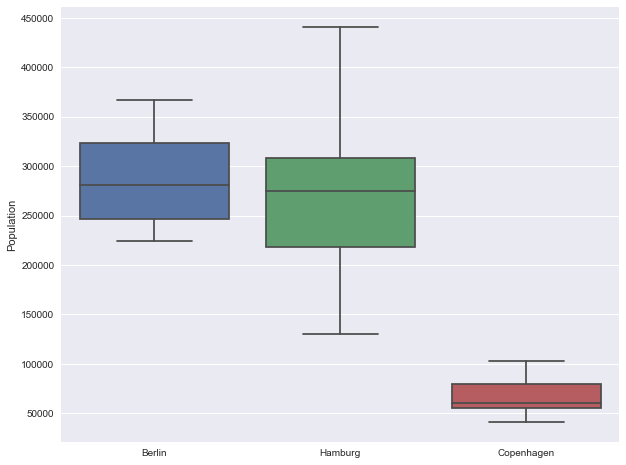

In [28]:
import seaborn as sns
plt.style.use('seaborn')
plt.figure(figsize =(10,8))
sns.boxplot(x= 'City', y = 'Pop', data = Boroughs )
plt.xlabel('')
plt.ylabel('Population')


Below the reader can get a quick overview of the difference of the populations in of the different boroughs. The districts/boroughs of Copenhagen have significantly less amount of people, whereas boroughs in Hamburg are comparable to Berlin but smaller on the whole. 


This gives further credence to the validity of using Copenhagens Boroughs to compare to neighborhoods in the German cities. Even the least populous Borough in Hamurg or Berlin has far more people than the most populous borough  

([<matplotlib.axis.YTick at 0xec7b810>,
 <a list of 7 Text yticklabel objects>)

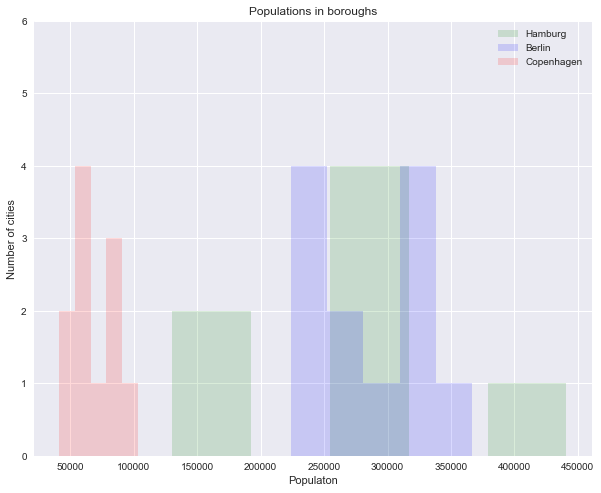

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
plt.hist(Ha_br['Pop'], color ='g', bins = 5,alpha = 0.15)
plt.hist(Be_br['Pop'], color = 'blue', bins = 5,alpha = 0.15)
plt.hist(Co_br['Pop'], color = 'r', bins = 5,alpha = 0.15)
plt.legend(['Hamburg', 'Berlin', 'Copenhagen'])
plt.xlabel('Populaton')
plt.ylabel('Number of cities')
plt.title('Populations in boroughs')
plt.yticks(np.arange(0,7,1))

#importantly the frame should be sorted so by area alphabetically so that I can get the alphabetised list of neighborhoods to merbe to the clustered neighborhoods.

## Geospacial coordinates for the areas

Now that the reader is somewhat familiar with the size of the cities, we will discard the population data as it is not needed for the analysis. The neighborhood frames will be merged and formatted to be optimal for coordinate extraction. We can concatenate the cities an neighborhoods for a single address

After some experimentation with the below code, the geolocator can work, but some locations will need to be changed if coordinates are to be extracted:

Amager Vest/Øst --> 'Amager', Nomenatim doesn not recognise them seperately.

Vesterbro/Kongens Enghave, Copenhagen --> 'Vesterbro'

Hamm (← Hamm-Mitte, Hamm-Nord & Hamm-Süd --> Hamm. 

In [30]:
Copenhagen_df.drop(Copenhagen_df[Copenhagen_df['Name'] == 'Amager Øst'].index,inplace = True)
Copenhagen_df.loc[Copenhagen_df['Name'] == 'Amager Vest','Name'] = 'Amager'
Copenhagen_df.loc[Copenhagen_df['Name'] == 'Vesterbro/Kongens Enghave','Name'] = 'Vesterbro'
Hamburg_df.loc[Hamburg_df['Name'] == 'Hamm (← Hamm-Mitte, Hamm-Nord & Hamm-Süd)','Name'] = 'Hamm'
Copenhagen_df.reset_index(inplace = True)

C:\Users\Jokubas\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Now that the locations are clear, we can concatenate them into a single dataframe holding the location addresses that Nomenatim can recongnise.

In [31]:
#Placeholder dataframes
Copen_geo = pd.DataFrame()
Hamburg_geo = pd.DataFrame()
Berlin_geo = pd.DataFrame()
# 
Copen_geo['Nbhood'] =  Copenhagen_df['Name'] + ', Copenhagen'
Hamburg_geo['Nbhood'] = Hamburg_df['Name'] + ', Hamburg'
Berlin_geo['Nbhood'] = Berlin_df['Neighborhood'] + ', Berlin'
#keeping a messy index for now
Locations = Copen_geo.append(Hamburg_geo).append(Berlin_geo)
Locations['Nbhood']

0              Amager, Copenhagen
1          Bispebjerg, Copenhagen
2      Brønshøj-Husum, Copenhagen
3            Indre By, Copenhagen
4            Nørrebro, Copenhagen
                 ...             
91          Waidmannslust, Berlin
92                 Lübars, Berlin
93               Wittenau, Berlin
94     Märkisches Viertel, Berlin
95            Borsigwalde, Berlin
Name: Nbhood, Length: 210, dtype: object

This is a very time consuming block of code to get the geo location data for the three cities. (~5-7 min loading time for 210 locations). 
If there is a quicker process(other services) that is available I highly suggest using that.

In [32]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geolocator = Nominatim(user_agent="http")

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
Locations['location'] = Locations['Nbhood'].apply(geocode)
Locations

,Nbhood,location
0,"Amager, Copenhagen","(Amager, Tårnby Kommune, Region Hovedstaden, D..."
1,"Bispebjerg, Copenhagen","(Bispebjerg, Københavns Kommune, Region Hoveds..."
2,"Brønshøj-Husum, Copenhagen","(Fritidscenteret Brønshøj-Husum, Frederikssund..."
3,"Indre By, Copenhagen","(Kulturhuset Indre By, Charlotte Ammundsens Pl..."
4,"Nørrebro, Copenhagen","(Nørrebro, København, Københavns Kommune, Regi..."
...,...,...
91,"Waidmannslust, Berlin","(Waidmannslust, Reinickendorf, 13469, Deutschl..."
92,"Lübars, Berlin","(Lübars, Reinickendorf, Deutschland, (52.61464..."
93,"Wittenau, Berlin","(Wittenau, Reinickendorf, Deutschland, (52.591..."
94,"Märkisches Viertel, Berlin","(Märkisches Viertel, Reinickendorf, 13439, Deu..."


Here I will be using a seperate object for manipulations , just because 'Locations' takes a long time to compile, should I make a mistake I would have to recompile. We also have to confirm that everything is as expected, and there are no nulls in the dataset. We check and there are no nulls in the 'location' column which means that geospacial data for all the areas has been retrieved successfully.

In [33]:
Lks = Locations.reset_index(drop = True)
Lks[Lks['location'].isna()]

,Nbhood,location


Now we finally can rettrieve a dataframe that holds neighborhoods of interest alongside their geospacial coordinates.

In [34]:
Lks['longitude'] = Lks['location'].apply(lambda x: x.longitude)
Lks['latitude'] = Lks['location'].apply(lambda x: x.latitude)
Lks_geo = Lks[['Nbhood','longitude','latitude']]
Lks_geo

,Nbhood,longitude,latitude
0,"Amager, Copenhagen",12.603853,55.624376
1,"Bispebjerg, Copenhagen",12.534000,55.710950
2,"Brønshøj-Husum, Copenhagen",12.501445,55.704536
3,"Indre By, Copenhagen",12.563889,55.683480
4,"Nørrebro, Copenhagen",12.544956,55.695894
...,...,...,...
205,"Waidmannslust, Berlin",13.321046,52.605993
206,"Lübars, Berlin",13.353020,52.614647
207,"Wittenau, Berlin",13.323320,52.591237
208,"Märkisches Viertel, Berlin",13.356532,52.599312


Need to have seperate colors for each city. This can be done with an indicator if function that turns a indexing number to a certain value if depending on the City.

In [35]:

map_cities = folium.Map(location=[54.0924, 12.0991], zoom_start=6.499)

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(Lks_geo['latitude'], Lks_geo['longitude'], Lks_geo['Nbhood']):
    label = folium.Popup(str(poi)  , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color= 'green',
        fill=True,
        fill_color= 'green',
        fill_opacity=0.1).add_to(map_cities)
#show map       
map_cities 
#This works but there seems to be a location insel newerk hamburg that needs to go.
#also I need to get these items in different colors for each city.

Looking from the map above we can visually confirm that we have the correct areas in our data set.We can also see that Insel Neuwerk, is an island that is 120km away Hamburg city centre but belongs to Hamburg Municipality legally, we will omit this since our client is unlikely to be interested to travel into this outlier area for practical reasons.

In [36]:
Lks_geo.drop(Lks_geo[Lks_geo['Nbhood'] == 'Insel Neuwerk, Hamburg'].index,inplace = True)
Lks_geo.reset_index(inplace= True, drop = True)
Lks_geo

C:\Users\Jokubas\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Nbhood,longitude,latitude
0,"Amager, Copenhagen",12.603853,55.624376
1,"Bispebjerg, Copenhagen",12.534000,55.710950
2,"Brønshøj-Husum, Copenhagen",12.501445,55.704536
3,"Indre By, Copenhagen",12.563889,55.683480
4,"Nørrebro, Copenhagen",12.544956,55.695894
...,...,...,...
204,"Waidmannslust, Berlin",13.321046,52.605993
205,"Lübars, Berlin",13.353020,52.614647
206,"Wittenau, Berlin",13.323320,52.591237
207,"Märkisches Viertel, Berlin",13.356532,52.599312


## Retrieving venues and preparing data for cluster analysis

Now that we have the data we can get the venues in each area, gather to get the most popular types and finally cluster the areas.

In [37]:
CLIENT_ID = 'XZGLPPX1CZNGLIHJ0DCOAQFPBETBD2HURQ0QIUULM05FI1MH' # your Foursquare ID
CLIENT_SECRET = 'A4KFWSFMPWVYVAVF3J130MLZOADPTEFIECSHG2QFDSAYRVLX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 300

Handy function to get the nearby vanues using longitude and lattitude data.

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=800):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Also a rather expensive code timewise. If there are any functions available that would gather the information faster. We shall keep the radius larger, but this is of course a prototype and should be tuned dependent on results. 

In [40]:
City_venues = getNearbyVenues(names=Lks_geo['Nbhood'],
                                   latitudes=Lks_geo['latitude'],
                                   longitudes=Lks_geo['longitude'], radius = 1200
                                  )


In [41]:
print('Total number of venues: ', City_venues.shape[0])
print('There are {} unique categories.'.format(len(City_venues['Venue Category'].unique())))

City_venues.groupby('Neighborhood').count()

Total number of venues:  8511
There are 414 unique categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adlershof, Berlin",31,31,31,31,31,31
"Alt-Hohenschönhausen, Berlin",39,39,39,39,39,39
"Alt-Treptow, Berlin",90,90,90,90,90,90
"Altglienicke, Berlin",6,6,6,6,6,6
"Baumschulenweg, Berlin",24,24,24,24,24,24
...,...,...,...,...,...,...
"Wilhelmsburg, Hamburg",18,18,18,18,18,18
"Wilstorf, Hamburg",13,13,13,13,13,13
"Winterhude, Hamburg",100,100,100,100,100,100


Now that we have a rather rich set of venues(>8,000) we can use that to translate it into numbers such that the KMeans algortithm would be able to interpret the information Onehot encoding will be used here.

In [42]:
# one hot encoding
Cities_onehot = pd.get_dummies(City_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Cities_onehot['Neighborhood'] = City_venues['Neighborhood'] 
Cities_onehot['Neighborhood']

# move neighborhood column to the first column 

col_position = list(Cities_onehot.columns).index('Neighborhood')

fixed_columns = [Cities_onehot.columns[col_position]] + list(Cities_onehot.columns[:col_position]) + list(Cities_onehot.columns[(col_position+1):])
Cities_onehot = Cities_onehot[fixed_columns]
#print(Toronto_onehot.shape)
print('This number should be 1 if there are no duplicate "Neighborhood" columns : ' , sum(sum([Cities_onehot.columns == 'Neighborhood'])))

Cities_onehot.head()

This number should be 1 if there are no duplicate "Neighborhood" columns :  1


,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Water Park,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"Amager, Copenhagen",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Amager, Copenhagen",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Amager, Copenhagen",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Amager, Copenhagen",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Amager, Copenhagen",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Then the frame needs to be grouped to get the desired feature list. By grouping we retain the information while reducing the number of rows to a manageable level.

In [43]:
Cities_grouped = Cities_onehot.groupby('Neighborhood').mean().reset_index()
print('Size of the one-hot: ', Cities_onehot.shape)
print('Size of the grouped: ', Cities_grouped.shape)
Cities_grouped

Size of the one-hot:  (8511, 414)
Size of the grouped:  (209, 414)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,...,Water Park,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"Adlershof, Berlin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,"Alt-Hohenschönhausen, Berlin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,"Alt-Treptow, Berlin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,"Altglienicke, Berlin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,"Baumschulenweg, Berlin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,"Wilhelmsburg, Hamburg",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
205,"Wilstorf, Hamburg",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.076923,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
206,"Winterhude, Hamburg",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
207,"Wohldorf-Ohlstedt, Hamburg",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Funrion to return top values, to summarise the neighborhoods atmosphere/type.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Cities_grouped['Neighborhood']

for ind in np.arange(Cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Cities_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adlershof, Berlin",Supermarket,Greek Restaurant,Hotel,Automotive Shop,Steakhouse,Asian Restaurant,Park,Hardware Store,Furniture / Home Store,Chinese Restaurant
1,"Alt-Hohenschönhausen, Berlin",Tram Station,Supermarket,Lake,Drugstore,Café,Ice Cream Shop,Steakhouse,Bakery,Bar,Go Kart Track
2,"Alt-Treptow, Berlin",Café,Nightclub,Italian Restaurant,Bakery,Park,Rock Club,Supermarket,Beer Garden,Bar,Soccer Field
3,"Altglienicke, Berlin",Supermarket,Food Truck,Shipping Store,Greek Restaurant,Farm,Electronics Store,Empanada Restaurant,Escape Room,Ethiopian Restaurant,Event Service
4,"Baumschulenweg, Berlin",Supermarket,Café,Park,Bakery,Drugstore,Tennis Court,Gas Station,Chinese Restaurant,Bus Stop,Smoke Shop
...,...,...,...,...,...,...,...,...,...,...,...
204,"Wilhelmsburg, Hamburg",Supermarket,German Restaurant,Bus Stop,Park,Restaurant,Athletics & Sports,Turkish Restaurant,Climbing Gym,Pet Store,Hotel
205,"Wilstorf, Hamburg",German Restaurant,Bus Stop,Supermarket,Water Park,Art Gallery,Business Service,Bus Station,Lake,Bar,Bakery
206,"Winterhude, Hamburg",Café,Drugstore,Supermarket,Bakery,Italian Restaurant,Park,German Restaurant,Sushi Restaurant,Trattoria/Osteria,Ice Cream Shop
207,"Wohldorf-Ohlstedt, Hamburg",German Restaurant,Forest,Metro Station,Convenience Store,Sports Club,Plaza,Ice Cream Shop,History Museum,Lawyer,Hotel


Here I check if the two dataframe 'Neighborhood' columns are ordered in the same, as this is the key to remerge the dataframes for plotting and analysis of the final results. This step is crucial since the 'Neighborhood' column will have to be removed for the KMeans algorithm. The order is the same which means we can move on. 


In [46]:
Cities_grouped['Neighborhood'] == neighborhoods_venues_sorted['Neighborhood']

0      True
1      True
2      True
3      True
4      True
       ... 
204    True
205    True
206    True
207    True
208    True
Name: Neighborhood, Length: 209, dtype: bool

Finally we can run the cluster analysis. I will pick 5 cluster labels for this prototype, the number of clusters should be tuned based on if the labelling of Copenhagen seems accurate to the client. 

In [56]:
kclusters = 5

Cities_grouped_clustering = Cities_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=7).fit(Cities_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted

ValueError: cannot insert Cluster Labels, already exists

To have a good  overview of the model results we can plot the distribution of cluster labels and see how they neighoborhoods in all cities fared in our classifier.


From the below graph we can see that clusters 0, 3 and 4 are have the most members using the model overall. Most of the neighborhoods overall have fallen in cluser 0. Clsuters 1 and 2 have an equal the amount of neighborhoods (11)

Number of neighborhoods in each cluster 
4    93
3    77
0    28
2    10
1     1
Name: Cluster Labels, dtype: int64


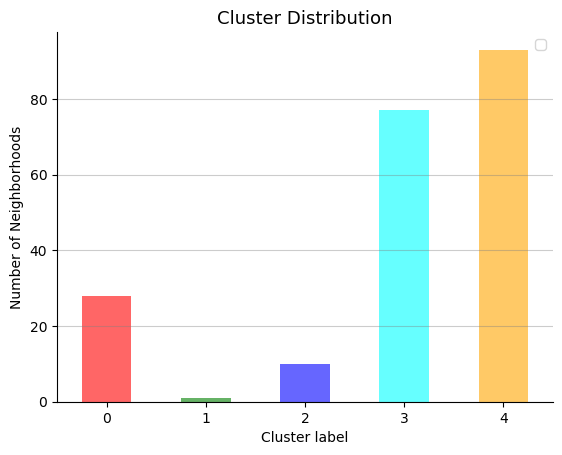

In [48]:
import seaborn as sns
plt.style.use('default')
#Colors to be used for each of the cluster labels
Clr = ['red','green','blue', 'cyan', 'orange']
#Formatting to give overall results of the classifier
print('Number of neighborhoods in each cluster ')
print(neighborhoods_venues_sorted['Cluster Labels'].value_counts())

Result_count = neighborhoods_venues_sorted['Cluster Labels'].value_counts().to_frame().reset_index()
Result_count.columns = ['Cluster', 'Num_of_hoods']
Result_count= Result_count.sort_values('Cluster')

#plotting formatting of the chart to maximise information communicated
Result_count.plot(kind = 'bar', x= 'Cluster' , y = 'Num_of_hoods', alpha = 0.6 ,color = Clr)
plt.grid(True, axis='y', alpha = 0.4, color = 'grey')
plt.xticks(rotation = 0)
plt.ylabel('Number of Neighborhoods',fontsize = 10)
plt.xlabel('Cluster label', fontsize = 10)
plt.title('Cluster Distribution', fontsize = 13 )
plt.legend([])
sns.despine() # using seaborn for convenience.


Now that we have seen how the algorithm has labeled the data overall, we can start start redistinguishing all boroughs and cities to obtain our final result of 3 citie labelled by their venue simialrity.

In [49]:
Lks_geo.columns

Index(['Nbhood', 'longitude', 'latitude'], dtype='object')

In [50]:
#Lks_geo = TOR_GDF
Cities_merged = Lks_geo

# to latitude/longitude for each neighborhood, such that we have latitude and cluster labels in one frame
Cities_merged  = Cities_merged.merge(neighborhoods_venues_sorted, left_on='Nbhood',right_on = 'Neighborhood')
#One last check for missing values
Cities_merged[Cities_merged['Cluster Labels'].isna()]['Cluster Labels']


Series([], Name: Cluster Labels, dtype: int32)

Heres a lot at 

In [51]:
Cities_merged

,Nbhood,longitude,latitude,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Amager, Copenhagen",12.603853,55.624376,4,"Amager, Copenhagen",Hotel,Grocery Store,Furniture / Home Store,Food Truck,Basketball Court,Auto Garage,Hardware Store,Discount Store,Pet Store,Bakery
1,"Bispebjerg, Copenhagen",12.534000,55.710950,4,"Bispebjerg, Copenhagen",Pizza Place,Café,Gym / Fitness Center,Bakery,Grocery Store,Park,Beer Bar,Sushi Restaurant,Burger Joint,Sculpture Garden
2,"Brønshøj-Husum, Copenhagen",12.501445,55.704536,4,"Brønshøj-Husum, Copenhagen",Park,Bakery,Supermarket,Pizza Place,Grocery Store,Plaza,Golf Course,Bar,Doner Restaurant,Café
3,"Indre By, Copenhagen",12.563889,55.683480,4,"Indre By, Copenhagen",Beer Bar,Café,Bakery,Coffee Shop,Cocktail Bar,Scandinavian Restaurant,Wine Bar,Burger Joint,Restaurant,Breakfast Spot
4,"Nørrebro, Copenhagen",12.544956,55.695894,4,"Nørrebro, Copenhagen",Café,Coffee Shop,Pizza Place,Beer Bar,Wine Bar,Gym / Fitness Center,Bakery,Thai Restaurant,Breakfast Spot,Playground
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,"Waidmannslust, Berlin",13.321046,52.605993,3,"Waidmannslust, Berlin",Supermarket,Drugstore,Gym / Fitness Center,Soccer Field,Pharmacy,Bakery,Greek Restaurant,Auto Dealership,Hardware Store,Lake
205,"Lübars, Berlin",13.353020,52.614647,4,"Lübars, Berlin",Park,Stables,Ice Cream Shop,Miscellaneous Shop,Restaurant,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant
206,"Wittenau, Berlin",13.323320,52.591237,3,"Wittenau, Berlin",Supermarket,Trattoria/Osteria,German Restaurant,Park,Italian Restaurant,Motorcycle Shop,ATM,Electronics Store,Bakery,Light Rail Station
207,"Märkisches Viertel, Berlin",13.356532,52.599312,3,"Märkisches Viertel, Berlin",Athletics & Sports,Supermarket,Italian Restaurant,Park,Greek Restaurant,Lake,Restaurant,Automotive Shop,Gym / Fitness Center,Bank


We can finally create a map that visualises the clustered neighborhoods.

In [52]:

map_clusters = folium.Map(location=[54.0924, 12.0991], zoom_start=6.499)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Cities_merged['latitude'], Cities_merged['longitude'], Cities_merged['Neighborhood'], Cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= Clr[cluster],
        fill=True,
        fill_color= Clr[cluster],
        fill_opacity=0.3).add_to(map_clusters)
#show map       
map_clusters

In [53]:
Hamburg_geo 

,Nbhood
0,"Altona-Altstadt, Hamburg"
1,"Altona-Nord, Hamburg"
2,"Bahrenfeld, Hamburg"
3,"Blankenese, Hamburg"
4,"Groß Flottbek, Hamburg"
...,...
99,"Tonndorf, Hamburg"
100,"Volksdorf, Hamburg"
101,"Wandsbek, Hamburg"
102,"Wellingsbüttel, Hamburg"


All I need is some inner joins, with cleaned dataframes(need to clean off the city labels) and I can finally rank the dataframes.

In [54]:
Copenhagen_df
Copenhagen_df
Hamburg_df

,Name,Borough,Pop
0,Altona-Altstadt,Altona,29170
1,Altona-Nord,Altona,24536
2,Bahrenfeld,Altona,30203
3,Blankenese,Altona,13730
4,Groß Flottbek,Altona,11111
...,...,...,...
99,Tonndorf,Wandsbek,15148
100,Volksdorf,Wandsbek,20978
101,Wandsbek,Wandsbek,36444
102,Wellingsbüttel,Wandsbek,10848
